In [1]:
!ls /kaggle/input/days-death-to-a-banana/

banana_days_471_synced.csv  banana_images_jpg


In [2]:
TRAIN = '/kaggle/input/days-death-to-a-banana/'

In [3]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 2048

model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 138MB/s]


In [4]:
import arrow
import base64
import pandas as pd
from glob import iglob
from io import BytesIO
from os.path import basename
from PIL import Image

THUMBNAIL_SIZE = (64, 64)

def embed(model, filename: str):
    with Image.open(fp=filename, mode='r') as image:
        return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)


# https://stackoverflow.com/a/952952
def flatten(arg):
    return [x for xs in arg for x in xs]

def png(filename: str) -> str:
    with Image.open(fp=filename, mode='r') as image:
        buffer = BytesIO()
        # our images are pretty big; let's shrink the hover images to thumbnail size
        image.resize(size=THUMBNAIL_SIZE).convert('RGB').save(buffer, format='png')
        return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

def get_picture_from_glob(arg: str, tag: str,) -> list:
    time_get = arrow.now()
    result = [pd.Series(data=[tag, basename(input_file), embed(model=model, filename=input_file), png(filename=input_file)],
                        index=['tag', 'name', 'value', 'png'] )
        for index, input_file in enumerate(list(iglob(pathname=arg))) if input_file.lower().endswith('jpg')]
    print('encoded {} rows of {}  in {}'.format(len(result), tag, arrow.now() - time_get))
    return result

time_start = arrow.now()
train_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TRAIN + '/*') }
train_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in train_dict.items()]))
print('done in {}'.format(arrow.now() - time_start))

encoded 471 rows of banana_images_jpg  in 0:01:20.357225
encoded 0 rows of banana_days_471_synced.csv  in 0:00:00.001220
done in 0:01:20.403011


In [5]:
label_df = pd.read_csv(filepath_or_buffer='/kaggle/input/days-death-to-a-banana/banana_days_471_synced.csv')
label_df

image_filename  days_left
0    banana_01_day_01.jpg          8
1    banana_02_day_01.jpg          8
2    banana_03_day_01.jpg          8
3    banana_04_day_01.jpg          8
4    banana_05_day_01.jpg          8
..                    ...        ...
466  banana_60_day_06.jpg          3
467  banana_61_day_06.jpg          3
468  banana_55_day_04.jpg          5
469  banana_56_day_03.jpg          6
470  banana_62_day_06.jpg          3

[471 rows x 2 columns]

In [6]:
train_df = train_df.merge(right=label_df, left_on='name', right_on='image_filename')

In [7]:
train_df['tag'] = 'dl' + train_df['days_left'].astype(str)

In [8]:
from sklearn.manifold import TSNE

train_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
train_df[['x', 'y']] = train_reducer.fit_transform(X=train_df['value'].apply(func=pd.Series))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 471 samples in 0.004s...
[t-SNE] Computed neighbors for 471 samples in 0.092s...
[t-SNE] Computed conditional probabilities for sample 471 / 471
[t-SNE] Mean sigma: 1.940703
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.354370
[t-SNE] KL divergence after 1000 iterations: 0.926880


In [9]:
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.plotting import figure
from bokeh.plotting import output_notebook
from bokeh.plotting import show
from bokeh.palettes import Turbo256
from bokeh.transform import factor_cmap

output_notebook()

datasource = ColumnDataSource(train_df[['png', 'tag', 'x', 'y']].sample(n=min(5000, len(train_df)-1), random_state=2025))
factor_count = max(train_df['tag'].nunique(), 3)
indices = np.linspace(0, len(Turbo256)-1, factor_count, dtype=int)
palette = [Turbo256[index] for index in indices]
mapper = factor_cmap(field_name = 'tag', palette=palette, factors=train_df['tag'].unique().tolist(), start=0, end=factor_count-1, )

plot_figure = figure(title='TSNE projection: bananas', width=1000, height=800, tools=('pan, wheel_zoom, reset'))

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@png' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 18px'>@tag</span>
    </div>
</div>
"""))

plot_figure.scatter(x='x', y='y', source=datasource, line_alpha=0.6, fill_alpha=0.6, size=6, color=mapper)
show(plot_figure)

Loading BokehJS ...

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df['value'].apply(pd.Series), train_df['days_left'], test_size=0.25, random_state=2025, stratify=train_df['days_left'])
linreg = LinearRegression().fit(X_train, y_train)
# print('model fit in {} iterations'.format(linreg.n_iter_[0]))
print('MAE: {:5.4f}'.format(mean_absolute_error(y_true=y_test, y_pred=linreg.predict(X=X_test))))


MAE: 48.5102


<Axes: xlabel='days_left'>

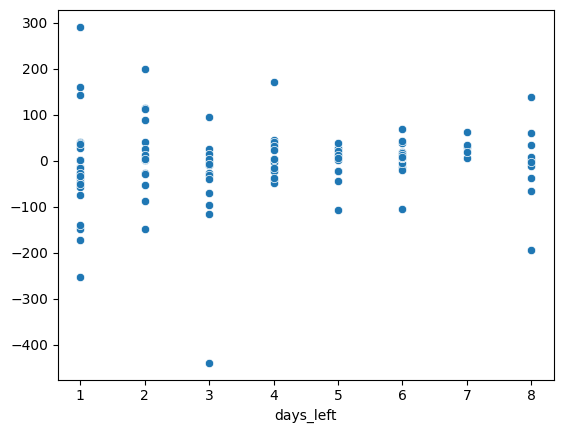

In [11]:
from seaborn import scatterplot

scatterplot(x=y_test, y=linreg.predict(X=X_test))